In [4]:
# Import packages

import rasterio
import rasterio.mask
from rasterio.plot import reshape_as_image 
from rasterio.plot import reshape_as_raster
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
import branca
import folium
import shapely
import json

In [5]:
# Reading incidents data
df = pd.read_csv("../Advanced Data Science Data/Incidents_clean.csv")

display(df)
# duration = endtime_new - starttime_new [min]


,type,starttime_new,endtime_new,vild_primair_wegnummer,primaire_locatie_lengtegraad,primaire_locatie_breedtegraad,duration
0,vehicle_obstruction,2019-08-28 12:11:32,2019-12-11 11:32:28,A1,4.974663,52.346931,151160.933333
1,vehicle_obstruction,2019-08-28 12:11:32,2019-12-11 11:32:28,A9,4.716725,52.514820,151160.933333
2,vehicle_obstruction,2019-08-28 12:11:32,2019-12-11 11:32:28,A9,4.738364,52.609730,151160.933333
3,vehicle_obstruction,2019-08-28 12:11:32,2019-12-11 11:32:28,A35,6.824692,52.204929,151160.933333
4,vehicle_obstruction,2019-08-28 12:11:32,2019-12-11 11:32:28,A4,4.346407,52.041920,151160.933333
...,...,...,...,...,...,...,...
88846,vehicle_obstruction,2019-12-31 23:43:49,2019-12-31 23:43:49,NaN,4.475721,51.893230,0.000000
88847,accident,2019-12-31 23:46:10,2019-12-31 23:46:10,N246,4.701406,52.443363,0.000000
88848,vehicle_obstruction,2019-12-31 23:47:01,2019-12-31 23:47:01,N31,5.922628,53.165226,0.000000
88849,vehicle_obstruction,2019-12-31 23:55:23,2019-12-31 23:55:23,A4,4.313686,51.442677,0.000000


In [6]:
# Importing CORUP shape file
COROP = gpd.read_file("../Advanced Data Science Data/COROP/B14_COROP_gebieden/B14_COROP_gebiedenPolygon.shp")

In [26]:
# Translate the geometry into epsg 4326 coordinates standard
COROP = COROP.to_crs(epsg=4326)
COROP.head(5)

,SHAPE_LENG,RUBRIEK_XS,RUBRIEK,JRSTATCODE,STATNAAM_X,STATNAAM,STATCODE_X,STATCODE,OBJECTID,geometry
0,102265.901559,None,coropgebied,2018CR19,None,Alkmaar en omgeving,None,CR19,35.0,"POLYGON ((4.72522 52.69385, 4.72885 52.69140, ..."
1,190305.888230,None,coropgebied,2018CR37,None,Noord-Limburg,None,CR37,36.0,"POLYGON ((5.93277 51.74194, 5.93589 51.74103, ..."
2,168527.142803,None,coropgebied,2018CR38,None,Midden-Limburg,None,CR38,37.0,"POLYGON ((5.89041 51.31367, 5.91065 51.30771, ..."
3,158991.993399,None,coropgebied,2018CR39,None,Zuid-Limburg,None,CR39,38.0,"POLYGON ((5.82368 51.06673, 5.82677 51.05587, ..."
4,326651.059478,None,coropgebied,2018CR40,None,Flevoland,None,CR40,39.0,"MULTIPOLYGON (((5.86218 52.52197, 5.85975 52.5..."


In [103]:
# Get zone names
zone_names = [i for i in COROP["STATNAAM"]]

# Get the geometry of the COROP
g = [i for i in COROP.geometry]

# Get the coordinates of the geometry
list_poly_coords = [shapely.geometry.mapping(g[i])['coordinates'][0] for i in range(len(g))]

# Turn the coordinates into numpy arrays
list_arr_coords = [np.array(list_poly_coords[i]) for i in range(len(list_poly_coords))]

# Organising dimension of arrays
for i in range(len(list_arr_coords)):
    # some polygon data has three dimentional array (not sure why) but the first dimention is always 1 so get rid of it
    if list_arr_coords[i].ndim == 3:
        list_arr_coords[i] = list_arr_coords[i][0]


for k in range(len(df)):
    for j in range(len(g)):
        if shapely.geometry.Point(df["primaire_locatie_lengtegraad"][k], df["primaire_locatie_breedtegraad"][k]).within(g[j]):
            df.loc[k, "zone"] = zone_names[j]
            break
        else:
            df.loc[k, "zone"] = "Unknown"


        


In [104]:
df

,type,starttime_new,endtime_new,vild_primair_wegnummer,primaire_locatie_lengtegraad,primaire_locatie_breedtegraad,duration,zone
0,vehicle_obstruction,2019-08-28 12:11:32,2019-12-11 11:32:28,A1,4.974663,52.346931,151160.933333,Groot-Amsterdam
1,vehicle_obstruction,2019-08-28 12:11:32,2019-12-11 11:32:28,A9,4.716725,52.514820,151160.933333,IJmond
2,vehicle_obstruction,2019-08-28 12:11:32,2019-12-11 11:32:28,A9,4.738364,52.609730,151160.933333,Alkmaar en omgeving
3,vehicle_obstruction,2019-08-28 12:11:32,2019-12-11 11:32:28,A35,6.824692,52.204929,151160.933333,Twente
4,vehicle_obstruction,2019-08-28 12:11:32,2019-12-11 11:32:28,A4,4.346407,52.041920,151160.933333,Agglomeratie 's-Gravenhage
...,...,...,...,...,...,...,...,...
88846,vehicle_obstruction,2019-12-31 23:43:49,2019-12-31 23:43:49,NaN,4.475721,51.893230,0.000000,Groot-Rijnmond
88847,accident,2019-12-31 23:46:10,2019-12-31 23:46:10,N246,4.701406,52.443363,0.000000,Zaanstreek
88848,vehicle_obstruction,2019-12-31 23:47:01,2019-12-31 23:47:01,N31,5.922628,53.165226,0.000000,Noord-Friesland
88849,vehicle_obstruction,2019-12-31 23:55:23,2019-12-31 23:55:23,A4,4.313686,51.442677,0.000000,West-Noord-Brabant


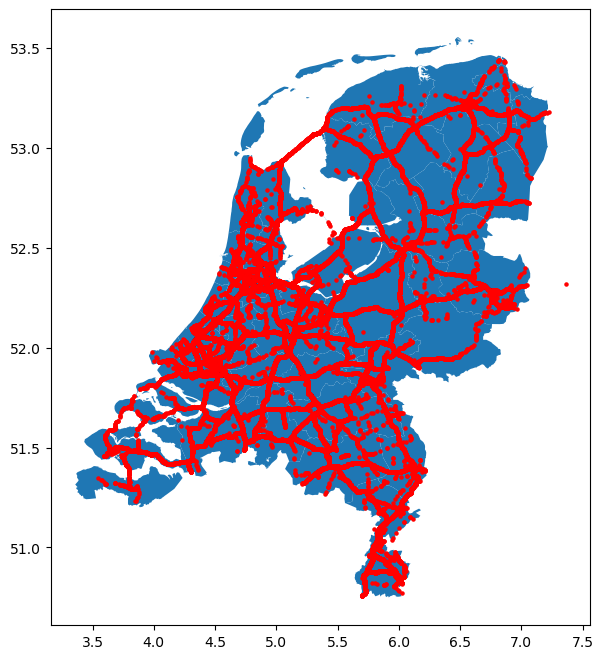

In [112]:
# Check if loaded correctly
fig, ax = plt.subplots(figsize = (8,8))
COROP.plot(ax=ax)
ax.scatter(df["primaire_locatie_lengtegraad"], df["primaire_locatie_breedtegraad"], s=5, c="red")
plt.show()

In [137]:
# Set up a dataframe for bubble map
columns_bubble = ["Zone", "Lat", "Lon", "Count"]
df_bubble = pd.DataFrame(columns=columns_bubble)

# input the zones and the coordinates of the centroid (centre of gravity)
df_bubble["Zone"] = zone_names
df_bubble["Lat"] = [list(shapely.geometry.Polygon(list_arr_coords[i]).centroid.coords)[0][1] for i in range(len(zone_names))]
df_bubble["Lon"] = [list(shapely.geometry.Polygon(list_arr_coords[i]).centroid.coords)[0][0] for i in range(len(zone_names))]

# Count the number of incidents in each zone
for i in range(len(zone_names)):
    df_bubble.loc[i, "Count"] = len(df[df["zone"] == zone_names[i]])

In [138]:
df_bubble

,Zone,Lat,Lon,Count
0,Alkmaar en omgeving,52.639448,4.758368,496
1,Noord-Limburg,51.464509,6.035926,988
2,Midden-Limburg,51.200997,5.875367,1196
3,Zuid-Limburg,50.883800,5.862185,2175
4,Flevoland,52.523277,5.860541,1654
5,Agglomeratie Haarlem,52.377009,4.611586,468
6,Oost-Groningen,53.080286,7.048793,307
7,IJmond,52.464935,4.576024,1017
8,Delfzijl en omgeving,53.328281,6.840129,47
9,Overig Groningen,53.369105,6.196435,1501


In [141]:
# "Unknown" incidents mostly accuredat a bridge or a tunnel (not in the COROP shape file)
df[df["zone"] == "Unknown"]

,type,starttime_new,endtime_new,vild_primair_wegnummer,primaire_locatie_lengtegraad,primaire_locatie_breedtegraad,duration,zone
237,vehicle_obstruction,2019-11-05 20:34:33,2019-11-05 21:50:08,A10,4.974095,52.377144,75.583333,Unknown
243,accident,2019-11-05 21:01:00,2019-11-05 22:16:08,A29,4.402657,51.692188,75.133333,Unknown
572,vehicle_obstruction,2019-11-06 16:45:11,2019-11-06 18:01:22,N62,3.798665,51.391853,76.183333,Unknown
1820,vehicle_obstruction,2019-11-13 23:35:39,2019-11-14 00:51:10,A6,5.138437,52.324982,75.516667,Unknown
2154,vehicle_obstruction,2019-11-14 16:55:43,2019-11-14 18:11:08,N62,3.798412,51.348705,75.416667,Unknown
...,...,...,...,...,...,...,...,...
78403,vehicle_obstruction,2019-11-29 09:22:04,2019-11-29 10:37:46,A10,4.974095,52.377144,75.700000,Unknown
78756,vehicle_obstruction,2019-11-29 18:55:03,2019-11-29 20:10:46,A10,4.974095,52.377144,75.716667,Unknown
83595,accident,2019-12-13 15:41:34,2019-12-13 16:57:11,A10,4.974095,52.377144,75.616667,Unknown
83874,accident,2019-12-13 23:49:52,2019-12-13 23:49:52,A76,6.024756,50.818905,0.000000,Unknown
